In [1]:
from IPython.display import display, Image
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
load_dotenv()
import os

os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

groq_api_key = os.getenv("GROQ_API_KEY")

model = ChatGroq(model_name = "meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key)

## ***Defining a user profile Schema***

In [3]:
from typing import TypedDict, List

class UserProfile(TypedDict):
    user_name: str # the user preferred name
    interests: List[str] ## a list of user interest
    


#### Saving schema to the store

In [5]:
user_profile: UserProfile = {
    'user_name': "Al Amin",
    'interests': ["Biking", "reading", 'Programming']
}

In [6]:
## use put method to save this data into the memory

from langgraph.store.memory import InMemoryStore

in_memory_store = InMemoryStore()

user_id = "1"
namespace_for_memory = (user_id, 'memory')

key = "user_profile"
value = user_profile

in_memory_store.put(namespace_for_memory, key, value)

## search the storing value

In [8]:
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memory'], 'key': 'user_profile', 'value': {'user_name': 'Al Amin', 'interests': ['Biking', 'reading', 'Programming']}, 'created_at': '2025-05-12T09:38:40.365853+00:00', 'updated_at': '2025-05-12T09:38:40.365853+00:00', 'score': None}


## we can also use get to retrieve a specific object by namespace abd key

In [9]:
profile = in_memory_store.get(namespace_for_memory, "user_profile")
profile.value

{'user_name': 'Al Amin', 'interests': ['Biking', 'reading', 'Programming']}

# ***Chatbot with profile Schema***

In [10]:
from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage



# Bind schema to model
model_with_structure = model.with_structured_output(UserProfile)

# Invoke the model to produce structured output that matches the schema
structured_output = model_with_structure.invoke([HumanMessage("My name is Al Amin, I like to bike, reading, and Programming.")])
structured_output

{'user_name': 'Al Amin', 'interests': ['biking', 'reading', 'Programming']}

#### Now, lets use this with out chatbot
- the only requires minor changes to the `write_memory` function
- we use `model_with_structured`, as defined above, to produce a profile that matches our schema

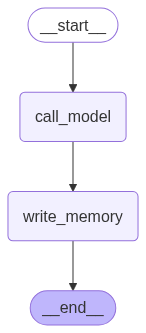

In [11]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """Create or update a user profile memory based on the user's chat history. 
This will be saved for long-term memory. If there is an existing memory, simply update it. 
Here is the existing memory (it may be empty): {memory}"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None
        
    # Format the existing memory in the instruction
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)

    # Invoke the model to produce structured output that matches the schema
    new_memory = model_with_structure.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing use profile memory
    key = "user_memory"
    store.put(namespace, key, new_memory)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [12]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Asslamualikum, my name is Al Amin and I like to bike around Bashundhara r/a, Dhaka and eat at bakeries.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Asslamualikum, my name is Al Amin and I like to bike around Bashundhara r/a, Dhaka and eat at bakeries.
================================== Ai Message ==================================

Wa Alaikumussalam Al Amin! Nice to meet you! It sounds like you enjoy exploring Bashundhara Residential Area (R/A) in Dhaka on your bike. That's a great way to stay active and appreciate the local scenery.

Bakeries are a wonderful treat! What's your favorite type of baked good? Do you have a go-to bakery in Bashundhara R/A or do you like to try different ones?

(By the way, I'll make sure to remember your name and interests for our future conversations!)


## Lets check the memory in the store

In [15]:
## Namespace for hte memory to save
user_id = "1"
namespace = ("memory", user_id)
key = "user_memory"

existing_memory = across_thread_memory.get(namespace, key)
existing_memory

Item(namespace=['memory', '1'], key='user_memory', value={'user_name': 'Al Amin', 'interests': ['biking', 'bakeries', 'Bashundhara R/A, Dhaka']}, created_at='2025-05-12T09:55:34.156603+00:00', updated_at='2025-05-12T09:55:34.156603+00:00')

## When can this fail?

[`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) is very useful, but what happens if we're working with a more complex schema? 

[Here's](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema) an example of a more complex schema, which we'll test below. 

This is a [Pydantic](https://docs.pydantic.dev/latest/) model that describes a user's preferences for communication and trust fall.

In [19]:
from typing import List, Optional

class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str

class TelegramPreferences(BaseModel):
    preferred_encoding: Optional[List[OutputFormat]] = None
    favorite_telegram_operators: Optional[List[OutputFormat]] = None
    preferred_telegram_paper: Optional[List[OutputFormat]] = None

class MorseCode(BaseModel):
    preferred_key_type: Optional[List[OutputFormat]] = None
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None

class Semaphore(BaseModel):
    preferred_flag_color: Optional[List[OutputFormat]] = None
    semaphore_skill_level: Optional[List[OutputFormat]] = None

class TrustFallPreferences(BaseModel):
    preferred_fall_height: Optional[List[OutputFormat]] = None
    trust_level: Optional[List[OutputFormat]] = None
    preferred_catching_technique: Optional[List[OutputFormat]] = None

class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore

class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences

class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

Now, let's try extraction of this schema using the `with_structured_output` method.

In [20]:
from pydantic import ValidationError

# Bind schema to model
model_with_structure = model.with_structured_output(TelegramAndTrustFallPreferences)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

# Invoke the model
try:
    model_with_structure.invoke(f"""Extract the preferences from the following conversation:
    <convo>
    {conversation}
    </convo>""")
except ValidationError as e:
    print(e)

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '>{\n  "pertinent_user_preferences": {\n    "communication_preferences": {\n      "telegram": {\n        "preferred_encoding": [\n          {"preference": "Morse code", "sentence_preference_revealed": "Morse, please. I love using a straight key."},\n          {"preference": "standard encoding", "sentence_preference_revealed": ""}\n        ],\n        "preferred_telegram_paper": [\n          {"preference": "Daredevil", "sentence_preference_revealed": "Perfect! Send it by your fastest carrier pigeon."}\n        ],\n        "favorite_telegram_operators": []\n      },\n      "morse_code": {\n        "preferred_key_type": [\n          {"preference": "straight key", "sentence_preference_revealed": "Morse, please. I love using a straight key."}\n        ],\n        "favorite_morse_abbreviations": []\n      },\n      "semaphore": {\n        "preferred_flag_color": [],\n        "semaphore_skill_level": []\n      }\n    },\n    "trust_fall_preferences": {\n      "preferred_fall_height": [\n        {"preference": "higher fall", "sentence_preference_revealed": "Tell him I\'m ready for a higher fall, and I prefer the diamond formation for catching."}\n      ],\n      "preferred_catching_technique": [\n        {"preference": "diamond formation", "sentence_preference_revealed": "Tell him I\'m ready for a higher fall, and I prefer the diamond formation for catching."}\n      ],\n      "trust_level": []\n    }\n  }\n}</function=TelegramAndTrustFallPreferences>'}}

If we naively extract more complex schemas, even using high capacity model like `gpt-4o`, it is prone to failure.


# ***Trustcall for creating and updating profile schemas***

As we can see, working with schemas can be tricky.

Complex schemas can be difficult to extract. 

In addition, updating even simple schemas can pose challenges.

Consider our above chatbot. 

We regenerated the profile schema *from scratch* each time we chose to save a new memory.

This is inefficient, potentially wasting model tokens if the schema contains a lot of information to re-generate each time.

Worse, we may loose information when regenerating the profile from scratch.

Addressing these problems is the motivation for [TrustCall](https://github.com/hinthornw/trustcall)!

This is an open-source library for updating JSON schemas developed by one [Will Fu-Hinthorn](https://github.com/hinthornw) on the LangChain team.

It's motivated by exactly these challenges while working on memory.

Let's first show simple usage of extraction with TrustCall on this list of [messages](https://python.langchain.com/docs/concepts/messages/).


In [25]:
# Conversation
conversation = [HumanMessage(content="Hi, I'm ALmain."), 
                AIMessage(content="Nice to meet you, Alamin."), 
                HumanMessage(content="I really like biking around Bashundhara r/a dhaka.")]

We use `create_extractor`, passing in the model as well as our schema as a [tool](https://python.langchain.com/docs/concepts/tools/).

With TrustCall, can supply supply the schema in various ways. 

For example, we can pass a JSON object / Python dictionary or Pydantic model.

Under the hood, TrustCall uses [tool calling](https://python.langchain.com/docs/concepts/tool_calling/) to produce [structured output](https://python.langchain.com/docs/concepts/structured_outputs/) from an input list of [messages](https://python.langchain.com/docs/concepts/messages/).

To force Trustcall to produce [structured output](https://python.langchain.com/docs/concepts/structured_outputs/), we can include the schema name in the `tool_choice` argument.

We can invoke the extractor with  the above conversation.

In [30]:
from trustcall import create_extractor

# Schema 
class UserProfile(BaseModel):
    """User profile schema with typed fields"""
    user_name: str = Field(description="The user's preferred name")
    interests: List[str] = Field(description="A list of the user's interests")

# Initialize the model
model = ChatGroq(model_name = "meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key)

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile"
)

# Instruction
system_msg = "Extract the user profile from the following conversation"

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+conversation})

When we invoke the extractor, we get a few things:

* `messages`: The list of `AIMessages` that contain the tool calls. 
* `responses`: The resulting parsed tool calls that match our schema.
* `response_metadata`: Applicable if updating existing tool calls. It says which of the responses correspond to which of the existing objects.


In [31]:
for m in result['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_w7y7)
 Call ID: call_w7y7
  Args:
    user_name: ALmain
    interests: ['biking', 'Bashundhara r/a dhaka']


In [32]:
schema = result['responses']
schema

[UserProfile(user_name='ALmain', interests=['biking', 'Bashundhara r/a dhaka'])]

In [34]:
schema[0].model_dump()

{'user_name': 'ALmain', 'interests': ['biking', 'Bashundhara r/a dhaka']}

In [35]:
result['response_metadata']

[{'id': 'call_w7y7'}]

Let's see how we can use it to *update* the profile.

For updating, TrustCall takes a set of messages as well as the existing schema. 

The central idea is that it prompts the model to produce a [JSON Patch](https://jsonpatch.com/) to update only the relevant parts of the schema.

This is less error-prone than naively overwriting the entire schema.

It's also more efficient since the model only needs to generate the parts of the schema that have changed.

We can save the existing schema as a dict.

We can use `model_dump()` to serialize a Pydantic model instance into a dict. 

We pass it to the `"existing"` argument along with the schema name, `UserProfile`. 

In [36]:
# Update the conversation
updated_conversation = [HumanMessage(content="Hi, I'm Al amin."), 
                        AIMessage(content="Nice to meet you, Alamin."), 
                        HumanMessage(content="I really like biking around Bashundhara r/a Dhaka."),
                        AIMessage(content="It sounds like you enjoy exploring Bashundhara Residential Area (R/A) in Dhaka on your bike. That's a great way to stay active and appreciate the local scenery.Bakeries are a wonderful treat! What's your favorite type of baked good? Do you have a go-to bakery in Bashundhara R/A or do you like to try different ones?Where do you go after biking?"),
                        HumanMessage(content="I really like to go to a bakery after biking."),]

In [38]:
# Update the instruction
system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result  = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation},
                                     {"existing": {"UpdateProfile": schema[0].model_dump()}})

In [39]:
updated_schema = result["responses"][0]
updated_schema.model_dump()

{'user_name': 'Al amin', 'interests': ['biking', 'bakery']}

In [40]:
for m in result['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_q79v)
 Call ID: call_q79v
  Args:
    user_name: Al amin
    interests: ['biking', 'bakery']


In [41]:
result['response_metadata']

[{'id': 'call_q79v'}]

## Now play with a challenging schema the previously has error.

In [43]:
bound = create_extractor(
    model,
    tools=[TelegramAndTrustFallPreferences],
    tool_choice="TelegramAndTrustFallPreferences",
)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

result = bound.invoke(
    f"""Extract the preferences from the following conversation:
<convo>
{conversation}
</convo>"""
)

# Extract the preferences
result["responses"][0]

BadRequestError: Error code: 400 - {'error': {'message': "'tools.0.function.description' : Value is not nullable", 'type': 'invalid_request_error'}}

### *Still this model can not solve this problem because this problem solve will be gpt-4o model. see you next time*

# **Chatbot with profile schema updating**

Now, let's bring Trustcall into our chatbot to create *and update* a memory profile.

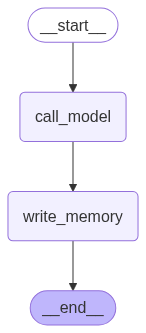

In [44]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
model = ChatGroq(model_name = "meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key)

# Schema 
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile", # Enforces use of the UserProfile tool
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Extraction instruction
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"      
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None
    
    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state["messages"], "existing": existing_profile})
    
    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [45]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Assalamualikum, i'm Al Amin")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Assalamualikum, i'm Al Amin
================================== Ai Message ==================================

Wa alaikumussalam, Al Amin! It's nice to meet you. How are you doing today?


In [46]:
# User input 
input_messages = [HumanMessage(content="I like to bike around Bashundhara r/a Dhaka")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around Bashundhara r/a Dhaka
================================== Ai Message ==================================

Biking around Bashundhara Residential Area (R/A) in Dhaka can be a great way to stay active and enjoy the outdoors. The area has some nice roads and scenery, I'm sure. Do you have a favorite route or spot that you like to visit while biking?


In [47]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'user_name': 'Al Amin',
  'user_location': 'Bashundhara r/a Dhaka',
  'interests': []},
 'created_at': '2025-05-12T12:00:34.975462+00:00',
 'updated_at': '2025-05-12T12:00:34.975462+00:00'}

In [48]:
existing_memory.value

{'user_name': 'Al Amin',
 'user_location': 'Bashundhara r/a Dhaka',
 'interests': []}

In [49]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

That sounds delicious! Bakeries can be a great place to indulge in sweet treats and freshly baked goods. Are you a fan of traditional Bangladeshi baked goods or do you prefer international flavors like croissants or pastries? Are there any specific bakeries in Bashundhara R/A or nearby that you particularly enjoy visiting?


In [50]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'user_name': 'Al Amin',
  'user_location': 'Bashundhara r/a Dhaka',
  'interests': ['biking', 'bakeries']},
 'created_at': '2025-05-12T12:02:34.842104+00:00',
 'updated_at': '2025-05-12T12:02:34.842104+00:00'}

In [51]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

As Al Amin, I'm excited to share some of my favorite bakeries in Dhaka with you! Being a resident of Bashundhara R/A, I've had the chance to try out a few amazing bakeries in the area.

One of my top recommendations is **Banani Bakeshop**. Their freshly baked croissants and danishes are simply divine! They also have a wide variety of cakes, pastries, and sandwiches.

Another favorite of mine is **The Baker's Oven** in Gulshan. Their sourdough bread and artisanal cakes are made with love, and you can taste the difference. Plus, their cozy atmosphere makes it a great spot to grab a coffee and pastry.

If you're looking for something a bit more budget-friendly, I'd suggest checking out **Nadia's Bake Shop** in Uttara. They offer a range of delicious baked goods, from traditional Bangladesh